<h1> Using MOMENT for Forecasting </h1>
<hr>

## Contents
### 1. A Quick Introduction to Forecasting
### 2. Loading MOMENT
### 3. Inputs and Outputs
### 4. Training the Forecasting Head

## 1. A Quick Introduction to Forecasting

Time series forecasting is another popular modeling task that involves predicting future values of a time series based on its historical patterns. For instance, in the context of stock market data, forecasting aims to estimate the future stock prices by analyzing past price movements and other relevant factors. In this tutorial, we will explore how to use MOMENT to tackle the time series forecasting in linearly probed setting. Mathematically, the time series forecasting problem can be defined as follows:

**Problem**: Given a time-series $T = [x_1, ..., x_L], \ x_i \in \mathbb{R}^{C}$ of length $L$ with $C$ channels (sensors or variables), the forecasting problem is to predict the next $H$ time-steps $[x_{L+1}, \dots, x_{L+H}]$. Depending on the length of the horizon, forecasting can be categorized as short or long-horizon

## 2. Loading MOMENT

We will first install the MOMENT package, load some essential packages and the pre-trained model.

MOMENT can be loaded in 4 modes: (1) `reconstruction`, (2) `embedding`, (3) `forecasting`, and (4) `classification`.

In the `reconstruction` mode, MOMENT reconstructs input time series, potentially containing missing values. We can solve imputation and anomaly detection problems in this mode. This mode is suitable for solving imputation and anomaly detection tasks. During pre-training, MOMENT is trained to predict the missing values within uniformly randomly masked patches (disjoint sub-sequences) of the input time series, leveraging information from observed data in other patches. As a result, MOMENT comes equipped with a pre-trained reconstruction head, enabling it to address imputation and anomaly detection challenges in a zero-shot manner! Check out the `anomaly_detection.ipynb` and `imputation.ipynb` notebooks for more details!

In the `embedding model`, MOMENT learns a $d$-dimensional embedding (e.g., $d=1024$ for `MOMENT-1-large`) for each input time series. These embeddings can be used for clustering and classification. MOMENT can learn embeddings in a zero-shot setting! Check out `representation_learning.ipynb` notebook for more details!

The `forecasting` and `classification` modes are used for forecasting and classification tasks, respectively. In these modes, MOMENT learns representations which are subsequently mapped to the forecast horizon or the number of classes, using linear forecasting and classification heads. Both the forecasting and classification head are randomly initialized, and therefore must be fine-tuned before use. Check out the `forecasting.ipynb` notebook for more details!

In [1]:
# !pip install numpy pandas matplotlib tqdm
# !pip install git+https://github.com/moment-timeseries-foundation-model/moment.git

In [ ]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': 192,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True, # Freeze the patch embedding layer
        'freeze_embedder': True, # Freeze the transformer encoder
        'freeze_head': False, # The linear forecasting head must be trained
    },
    # local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)

/home/kimoton/tsfoundations/.venv/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=1024, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
  

/home/kimoton/tsfoundations/.venv/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


In [ ]:
print("Unfrozen parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print('    ', name)

Unfrozen parameters:
     head.linear.weight
     head.linear.bias


## 3. Inputs and Outputs

Let's begin by performing a forward pass through MOMENT and examining its outputs!

MOMENT takes 3 inputs:

1. An input time series of length $T = 512$ timesteps and $C$ channels, and
2. Two optional masks, both of length $T = 512$.
    - The input mask is utilized to regulate the time steps or patches that the model should attend to. For instance, in the case of shorter time series, you may opt not to attend to padding. To implement this, you can provide an input mask with zeros in the padded locations.
    - The second mask, referred to simply as mask, denotes masked or unobserved values. We employ mask tokens to replace all patches containing any masked time step (for further details, refer to Section 3.2 in our paper). MOMENT can attend to these mask tokens during reconstruction.
    - By default, all time steps are observed and attended to.

MOMENT returns a `TimeseriesOutputs` object. Since this is a forecasting task, it returns a `forecast` of the input.

In [5]:
from pprint import pprint
import torch

# takes in tensor of shape [batchsize, n_channels, context_length]
x = torch.randn(16, 1, 512)
output = model(x_enc=x)
pprint(output)

/home/kimoton/tsfoundations/.venv/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/kimoton/tsfoundations/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TimeseriesOutputs(forecast=tensor([[[ 0.0121,  0.0407, -0.0751,  ...,  0.0156, -0.0966, -0.1609]],

        [[ 0.1444,  0.0701, -0.0320,  ...,  0.1084, -0.0145, -0.1245]],

        [[ 0.0067, -0.0542, -0.0511,  ...,  0.1571, -0.0550, -0.1038]],

        ...,

        [[ 0.1943,  0.0763,  0.0846,  ...,  0.1903,  0.1030, -0.1534]],

        [[ 0.0309,  0.0504, -0.0530,  ...,  0.1777, -0.0872, -0.1245]],

        [[ 0.0697, -0.0744, -0.0058,  ...,  0.0054,  0.0054, -0.2260]]],
       grad_fn=<AddBackward0>),
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]),
                  pretrain_mask=None,
                  reconstruction=None,
                  embedding

## 4. Training the Forecasting Head

MOMENT is pre-trained using a reconstruction head and a reconstruction head. To use MOMENT for forecasting, we replace the reconstruction head to a forecasting head. The forecasting head is a randomly initilized linear layer which maps MOMENT's embeddings to the forecasting horizon. 

**The forecasting head is randomly initialized, so it must be trained on your data.**

Below, we show a quick example of how we can train the forecasting head. In these experiments, we will use Hourly Electricity Transformer Temperature (ETTh1) dataset introduced by [Zhou et al., 2020](https://arxiv.org/abs/2012.07436). Check out [ETDataset](https://github.com/zhouhaoyi/ETDataset) for more information! This dataset is widely use to benchmark long-horizon forecasting models. 

In this experiment, MOMENT will take multi-variate time series as input, and predict the next 192 time steps, i.e. the forecast horizon is set to 192. We will fine-tune the model using Mean Squarred Error (MSE), and report both MSE and the Mean Absolute Error (MAE) of the fine-tuned model. Since MOMENT is already pre-trained on millions of time series, we only need to fine-tune it for 1 epoch!

We implemented a simple forecasting dataset class in `moment.data.informer_dataset`. `moment.utils.forecasting_metrics` contains implementations for MSE and MAE.

### 4.1 Model Finetuning

In [ ]:
import numpy as np
import torch
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

from momentfm.utils.utils import control_randomness
from momentfm.data.informer_dataset import InformerDataset
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

# Set random seeds for PyTorch, Numpy etc.
control_randomness(seed=13)

# Load data
train_dataset = InformerDataset(data_split="train", random_seed=13, forecast_horizon=192)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = InformerDataset(data_split="test", random_seed=13, forecast_horizon=192)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cur_epoch = 0
max_epoch = 1

# Move the model to the GPU
model = model.to(device)

# Move the loss function to the GPU
criterion = criterion.to(device)

# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Create a OneCycleLR scheduler
max_lr = 1e-4
total_steps = len(train_loader) * max_epoch
scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.3)

# Gradient clipping value
max_norm = 5.0

while cur_epoch < max_epoch:
    losses = []
    for timeseries, forecast, input_mask in tqdm(train_loader, total=len(train_loader)):
        # Move the data to the GPU
        timeseries = timeseries.float().to(device)
        input_mask = input_mask.to(device)
        forecast = forecast.float().to(device)

        with torch.cuda.amp.autocast():
            output = model(x_enc=timeseries, input_mask=input_mask)

        loss = criterion(output.forecast, forecast)

        # Scales the loss for mixed precision training
        scaler.scale(loss).backward()

        # Clip gradients
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        losses.append(loss.item())

    losses = np.array(losses)
    average_loss = np.average(losses)
    print(f"Epoch {cur_epoch}: Train loss: {average_loss:.3f}")

    # Step the learning rate scheduler
    scheduler.step()
    cur_epoch += 1

    # Evaluate the model on the test split
    trues, preds, histories, losses = [], [], [], []
    model.eval()
    with torch.no_grad():
        for timeseries, forecast, input_mask in tqdm(test_loader, total=len(test_loader)):
        # Move the data to the GPU
            timeseries = timeseries.float().to(device)
            input_mask = input_mask.to(device)
            forecast = forecast.float().to(device)

            with torch.cuda.amp.autocast():
                output = model(x_enc=timeseries, input_mask=input_mask)

            loss = criterion(output.forecast, forecast)
            losses.append(loss.item())

            trues.append(forecast.detach().cpu().numpy())
            preds.append(output.forecast.detach().cpu().numpy())
            histories.append(timeseries.detach().cpu().numpy())

    losses = np.array(losses)
    average_loss = np.average(losses)
    model.train()

    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)
    histories = np.concatenate(histories, axis=0)

    metrics = get_forecasting_metrics(y=trues, y_hat=preds, reduction='mean')

    print(f"Epoch {cur_epoch}: Test MSE: {metrics.mse:.3f} | Test MAE: {metrics.mae:.3f}")


/tmp/ipykernel_1037970/1686837204.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|                                                                                                             | 0/993 [00:00<?, ?it/s]/tmp/ipykernel_1037970/1686837204.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/kimoton/tsfoundations/.venv/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two 

Epoch 0: Train loss: 0.471


  0%|                                                                                                             | 0/337 [00:00<?, ?it/s]/tmp/ipykernel_1037970/1686837204.py:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 337/337 [03:15<00:00,  1.72it/s]

Epoch 1: Test MSE: 0.420 | Test MAE: 0.430


### 4.2 Visualization

Next, let's visualize the forecasts for a sample from the ETTh1 dataset and compare it with the ground truth forecast for the given time series.

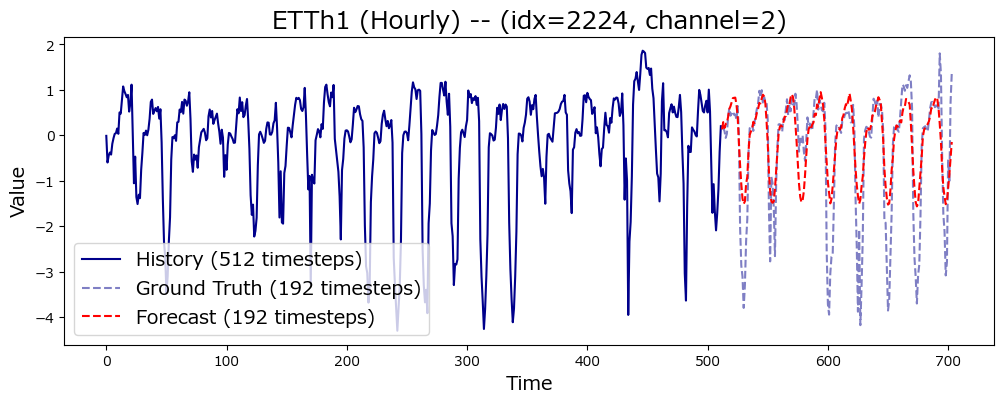

In [ ]:
import matplotlib.pyplot as plt

# Assuming histories, trues, and preds are your lists containing the data
# Extracting the first data point

channel_idx = np.random.randint(0, 7) # There are 7 channels in this dataset
time_index = np.random.randint(0, trues.shape[0])

history = histories[time_index, channel_idx, :]
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

plt.figure(figsize=(12, 4))

# Plotting the first time series from history
plt.plot(range(len(history)), history, label='History (512 timesteps)', c='darkblue')

# Plotting ground truth and prediction
num_forecasts = len(true)

offset = len(history)
plt.plot(range(offset, offset + len(true)), true, label='Ground Truth (192 timesteps)', color='darkblue', linestyle='--', alpha=0.5)
plt.plot(range(offset, offset + len(pred)), pred, label='Forecast (192 timesteps)', color='red', linestyle='--')

plt.title(f"ETTh1 (Hourly) -- (idx={time_index}, channel={channel_idx})", fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=14)
plt.show()

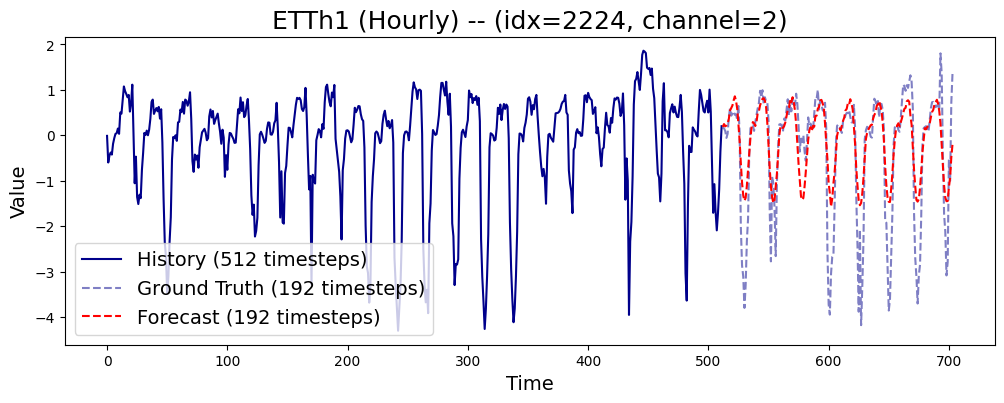

In [ ]:
import matplotlib.pyplot as plt

# Assuming histories, trues, and preds are your lists containing the data
# Extracting the first data point

channel_idx = np.random.randint(0, 7) # There are 7 channels in this dataset
time_index = np.random.randint(0, trues.shape[0])

history = histories[time_index, channel_idx, :]
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

plt.figure(figsize=(12, 4))

# Plotting the first time series from history
plt.plot(range(len(history)), history, label='History (512 timesteps)', c='darkblue')

# Plotting ground truth and prediction
num_forecasts = len(true)

offset = len(history)
plt.plot(range(offset, offset + len(true)), true, label='Ground Truth (192 timesteps)', color='darkblue', linestyle='--', alpha=0.5)
plt.plot(range(offset, offset + len(pred)), pred, label='Forecast (192 timesteps)', color='red', linestyle='--')

plt.title(f"ETTh1 (Hourly) -- (idx={time_index}, channel={channel_idx})", fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### 4.3 Results Interpretation: MOMENT Performs Well for Forecasting in Limited Supervision Settings

Here, we can see that MOMENT **trained for 1 epoch only, without any hyperparameter tuning**, can forecast time series well! 

In [1]:
### 5.1 データの読み込みと前処理

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch

# Excelファイルの読み込み
excel_file_path = "../data/ss/agentic-ai.xlsx"
df = pd.read_excel(excel_file_path)

# データの基本情報を確認
print("データの形状:", df.shape)
print("\nカラム名:")
print(df.columns.tolist())
print("\nデータの先頭5行:")
print(df.head())
print("\nデータの型:")
print(df.dtypes)
print("\n欠損値の確認:")
print(df.isnull().sum())


ModuleNotFoundError: No module named 'pandas'

In [ ]:
# データの可視化と前処理
plt.figure(figsize=(15, 10))

# 数値カラムを特定
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"数値カラム: {numeric_cols}")

# 時系列データが複数列ある場合の可視化
if len(numeric_cols) > 0:
    n_cols = min(len(numeric_cols), 4)
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()

    for i, col in enumerate(numeric_cols[:n_rows*n_cols]):
        if i < len(axes):
            axes[i].plot(df[col])
            axes[i].set_title(f'{col}の時系列データ')
            axes[i].set_xlabel('時間')
            axes[i].set_ylabel('値')

    # 余った軸を非表示
    for i in range(len(numeric_cols), n_rows*n_cols):
        if i < len(axes):
            axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()
else:
    print("数値データが見つかりません。データを確認してください。")


In [ ]:
### 5.2 カスタムデータセットクラスの作成

class CustomTimeSeriesDataset(Dataset):
    """カスタム時系列データセット"""

    def __init__(self, data, context_length=512, forecast_horizon=192, scaler=None):
        """
        Args:
            data: 時系列データ (pandas DataFrame)
            context_length: 入力系列の長さ
            forecast_horizon: 予測期間の長さ
            scaler: データの正規化器
        """
        self.context_length = context_length
        self.forecast_horizon = forecast_horizon

        # 数値カラムのみを使用
        numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
        self.data = data[numeric_cols].values.astype(np.float32)

        # データの正規化
        if scaler is None:
            self.scaler = StandardScaler()
            self.data = self.scaler.fit_transform(self.data)
        else:
            self.scaler = scaler
            self.data = self.scaler.transform(self.data)

        # 有効なインデックスを計算
        self.valid_indices = list(range(
            context_length,
            len(self.data) - forecast_horizon + 1
        ))

        print(f"データセット情報:")
        print(f"  データ形状: {self.data.shape}")
        print(f"  文脈長: {context_length}")
        print(f"  予測期間: {forecast_horizon}")
        print(f"  有効サンプル数: {len(self.valid_indices)}")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        """データセットからサンプルを取得"""
        actual_idx = self.valid_indices[idx]

        # 文脈データ（過去のデータ）
        context_start = actual_idx - self.context_length
        context_end = actual_idx
        context = self.data[context_start:context_end]  # [context_length, n_features]

        # 予測対象データ（未来のデータ）
        forecast_start = actual_idx
        forecast_end = actual_idx + self.forecast_horizon
        forecast = self.data[forecast_start:forecast_end]  # [forecast_horizon, n_features]

        # MOMENTの入力形式に変換: [n_features, context_length]
        context = torch.tensor(context.T, dtype=torch.float32)
        forecast = torch.tensor(forecast.T, dtype=torch.float32)

        # 入力マスク（すべてのタイムステップを有効にする）
        input_mask = torch.ones(self.context_length, dtype=torch.float32)

        return context, forecast, input_mask

# データセットの作成
if len(numeric_cols) > 0:
    # データが十分に長い場合のみデータセットを作成
    if len(df) >= 512 + 192:
        dataset = CustomTimeSeriesDataset(df, context_length=512, forecast_horizon=192)
        print(f"\nデータセットが正常に作成されました。")
    else:
        print(f"\nデータが短すぎます。最低限必要な長さ: {512 + 192}, 実際の長さ: {len(df)}")
        print("より短い文脈長と予測期間を使用します。")

        # データに適した長さに調整
        context_length = min(256, len(df) // 2)
        forecast_horizon = min(64, len(df) - context_length)

        if context_length > 0 and forecast_horizon > 0:
            dataset = CustomTimeSeriesDataset(df, context_length=context_length, forecast_horizon=forecast_horizon)
            print(f"調整されたデータセットが作成されました。")
        else:
            print("データが短すぎてデータセットを作成できません。")
else:
    print("数値データがないため、データセットを作成できません。")


In [ ]:
### 5.3 カスタムデータ用のMOMENTモデルセットアップ

# データセットが作成できた場合のみモデルを設定
if 'dataset' in locals():
    # カスタムデータに適したMOMENTモデルを作成
    forecast_horizon = dataset.forecast_horizon

    custom_model = MOMENTPipeline.from_pretrained(
        "AutonLab/MOMENT-1-large",
        model_kwargs={
            'task_name': 'forecasting',
            'forecast_horizon': forecast_horizon,
            'head_dropout': 0.1,
            'weight_decay': 0,
            'freeze_encoder': True,
            'freeze_embedder': True,
            'freeze_head': False,
        },
    )

    custom_model.init()

    print(f"カスタムモデルが初期化されました。")
    print(f"予測期間: {forecast_horizon}")
    print(f"データの特徴量数: {dataset.data.shape[1]}")

    # モデルをGPUに移動
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    custom_model = custom_model.to(device)
    print(f"使用デバイス: {device}")

    # データローダーの作成
    batch_size = min(8, len(dataset))  # データが少ない場合はバッチサイズを調整
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print(f"データローダーが作成されました。バッチサイズ: {batch_size}")
else:
    print("データセットが作成されていないため、モデルのセットアップをスキップします。")


In [ ]:
### 5.4 カスタムデータでのモデル訓練

if 'custom_model' in locals() and 'dataloader' in locals():
    # 訓練とテストデータの分割（80:20）
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 訓練設定
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(custom_model.parameters(), lr=1e-4)

    criterion = criterion.to(device)

    # 訓練設定
    max_epoch = 3  # より多くのエポック
    scaler = torch.amp.GradScaler('cuda' if device.type == 'cuda' else 'cpu')

    # 学習率スケジューラー
    total_steps = len(train_loader) * max_epoch
    scheduler = OneCycleLR(optimizer, max_lr=1e-4, total_steps=total_steps, pct_start=0.3)

    print(f"訓練開始:")
    print(f"  訓練サンプル数: {len(train_dataset)}")
    print(f"  テストサンプル数: {len(test_dataset)}")
    print(f"  エポック数: {max_epoch}")

    # 訓練ループ
    train_losses = []
    test_losses = []

    for epoch in range(max_epoch):
        # 訓練フェーズ
        custom_model.train()
        epoch_train_losses = []

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{max_epoch} [Train]')
        for timeseries, forecast, input_mask in train_pbar:
            timeseries = timeseries.float().to(device)
            input_mask = input_mask.to(device)
            forecast = forecast.float().to(device)

            optimizer.zero_grad()

            with torch.amp.autocast(device.type):
                output = custom_model(x_enc=timeseries, input_mask=input_mask)
                loss = criterion(output.forecast, forecast)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(custom_model.parameters(), 5.0)

            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            epoch_train_losses.append(loss.item())
            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = np.mean(epoch_train_losses)
        train_losses.append(avg_train_loss)

        # テストフェーズ
        custom_model.eval()
        epoch_test_losses = []

        with torch.no_grad():
            test_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{max_epoch} [Test]')
            for timeseries, forecast, input_mask in test_pbar:
                timeseries = timeseries.float().to(device)
                input_mask = input_mask.to(device)
                forecast = forecast.float().to(device)

                with torch.amp.autocast(device.type):
                    output = custom_model(x_enc=timeseries, input_mask=input_mask)
                    loss = criterion(output.forecast, forecast)

                epoch_test_losses.append(loss.item())
                test_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_test_loss = np.mean(epoch_test_losses)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    print("訓練が完了しました！")

else:
    print("モデルまたはデータローダーが利用できないため、訓練をスキップします。")


In [ ]:
### 5.5 学習結果の可視化

if 'train_losses' in locals() and 'test_losses' in locals():
    # 損失の推移をプロット
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
    plt.plot(range(1, len(test_losses) + 1), test_losses, 'r-', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
    plt.plot(range(1, len(test_losses) + 1), test_losses, 'r-', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Log Scale)')
    plt.title('Training and Test Loss (Log Scale)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"最終訓練損失: {train_losses[-1]:.4f}")
    print(f"最終テスト損失: {test_losses[-1]:.4f}")
else:
    print("学習結果がないため、可視化をスキップします。")


In [ ]:
### 5.6 予測結果の可視化

if 'custom_model' in locals() and 'dataset' in locals():
    # テストデータから予測を生成
    custom_model.eval()

    # テストサンプルを一つ選択
    test_idx = np.random.randint(0, len(test_dataset))
    context, true_forecast, input_mask = test_dataset[test_idx]

    # バッチ次元を追加
    context_batch = context.unsqueeze(0).to(device)
    input_mask_batch = input_mask.unsqueeze(0).to(device)

    # 予測の実行
    with torch.no_grad():
        with torch.amp.autocast(device.type):
            output = custom_model(x_enc=context_batch, input_mask=input_mask_batch)
            predicted_forecast = output.forecast.squeeze(0).cpu()

    # データを元のスケールに戻す
    context_np = context.numpy().T  # [context_length, n_features]
    true_forecast_np = true_forecast.numpy().T  # [forecast_horizon, n_features]
    predicted_forecast_np = predicted_forecast.numpy().T  # [forecast_horizon, n_features]

    # 逆正規化
    context_original = dataset.scaler.inverse_transform(context_np)
    true_forecast_original = dataset.scaler.inverse_transform(true_forecast_np)
    predicted_forecast_original = dataset.scaler.inverse_transform(predicted_forecast_np)

    # 全ての特徴量について可視化
    n_features = context_original.shape[1]
    n_cols = min(n_features, 3)
    n_rows = (n_features + n_cols - 1) // n_cols

    plt.figure(figsize=(15, 5*n_rows))

    for i in range(n_features):
        if i < n_rows * n_cols:
            plt.subplot(n_rows, n_cols, i+1)

            # 文脈データ（過去）
            context_x = range(len(context_original))
            plt.plot(context_x, context_original[:, i], 'b-', label='過去のデータ', linewidth=2)

            # 真の予測値
            forecast_x = range(len(context_original), len(context_original) + len(true_forecast_original))
            plt.plot(forecast_x, true_forecast_original[:, i], 'g--', label='実際の値', linewidth=2, alpha=0.7)

            # 予測値
            plt.plot(forecast_x, predicted_forecast_original[:, i], 'r--', label='予測値', linewidth=2)

            # 境界線を追加
            plt.axvline(x=len(context_original)-1, color='gray', linestyle=':', alpha=0.5, label='予測開始点')

            plt.xlabel('時間')
            plt.ylabel('値')
            plt.title(f'特徴量 {i+1}の時系列予測結果')
            plt.legend()
            plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 予測精度の計算
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    mse = mean_squared_error(true_forecast_original, predicted_forecast_original)
    mae = mean_absolute_error(true_forecast_original, predicted_forecast_original)

    print(f"予測精度指標:")
    print(f"  平均二乗誤差 (MSE): {mse:.4f}")
    print(f"  平均絶対誤差 (MAE): {mae:.4f}")

    # 特徴量ごとの精度
    print(f"\n特徴量ごとの精度:")
    for i in range(n_features):
        feature_mse = mean_squared_error(true_forecast_original[:, i], predicted_forecast_original[:, i])
        feature_mae = mean_absolute_error(true_forecast_original[:, i], predicted_forecast_original[:, i])
        print(f"  特徴量 {i+1} - MSE: {feature_mse:.4f}, MAE: {feature_mae:.4f}")

else:
    print("モデルまたはデータセットが利用できないため、予測結果の可視化をスキップします。")
